### Allstate Claims Severity
When you’ve been devastated by a serious car accident, your focus is on the things that matter the most: family, friends, and other loved ones. Pushing paper with your insurance agent is the last place you want your time or mental energy spent. This is why Allstate, a personal insurer in the United States, is continually seeking fresh ideas to improve their claims service for the over 16 million households they protect.
Allstate is currently developing automated methods of predicting the cost, and hence severity, of claims. In this recruitment challenge, Kagglers are invited to show off their creativity and flex their technical chops by creating an algorithm which accurately predicts claims severity. Aspiring competitors will demonstrate insight into better ways to predict claims severity for the chance to be part of Allstate’s efforts to ensure a worry-free customer experience.

## Posing as a Machine Learning Problem.
* It is also a supervised Machine learning problem as we have target values for train data.
* Target variable is a Loss (claim severity) which is numeric in type. As the target variable is numeric and loss value we can pose this problem as a Regression problem. 
* We have train data of shape - (188318, 132). And the target feature is a a continous numerical feature.
* Train dataset contains categorical and continuous features. 
* GOAL:- Our task is to predict severity of the claim for a new household, predict future loss based on given features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder,LabelBinarizer

from scipy import stats
import seaborn as sns
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Load Data
* Load train data into trainData dataframe
* Load test data into testData dataframe

In [2]:
trainData = pd.read_csv('train.csv',nrows=188318)
testData = pd.read_csv('test.csv')

print('Shape of train data: ',trainData.shape)
print('Shape of test data: ',testData.shape)

Shape of train data:  (188318, 132)
Shape of test data:  (125546, 131)


## Observations:
* Train Data :  188318 rows and 132 features/columns along with target variables.
* Test Data : 125546 rows and 131 features/columns where target feature is not present.
* All feature names are made anonymous. So understanding features and feature engineering is not feasible.

## Overview of data

In [3]:
print('Overview of train in data:')
print(trainData.info())
print('Overview of test data:')
print(testData.info())

Overview of train in data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB
None
Overview of test data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125546 entries, 0 to 125545
Columns: 131 entries, id to cont14
dtypes: float64(14), int64(1), object(116)
memory usage: 125.5+ MB
None


### Observations:
* Train data contains 130 distinct features excluding id and target variable(loss).
* Features contains both categorical and numerical features.
* Total 130 features comprises of 14 numerical and 116 categorical features. 

### Checking for missing values

In [4]:
print('Missing values in Train data:',pd.isnull(trainData).values.any())
print('Missing values in Test  data:',pd.isnull(testData).values.any())

Missing values in Train data: False
Missing values in Test  data: False


### Observations:
* There are no missing values in both train & test dataset.
* If dataset contains missing values then we can either drop them or we can replace them by an aggregate value such as mean or median.

### Seperating Categorical  Numerical features in Train data

In [5]:
trainCategorical = list(trainData.select_dtypes(include=['object']).columns)
print("Categorical features in Train data : ",len(trainCategorical))

trainNumerical = [i for i in list(trainData.select_dtypes(include=['float64', 'int64']).columns) if i not in ['loss', 'id']]
print("Numerical features in Train data : ",len(trainNumerical))

Categorical features in Train data :  116
Numerical features in Train data :  14


### Unique values in Categorical features

In [6]:
uniqueCategorical = []
for i in trainCategorical:
    uniqueCategorical.append(len(trainData[i].unique()))
    

uniqueCategories = pd.DataFrame()
uniqueCategories['Category'] = trainCategorical
uniqueCategories['Unique Values'] = uniqueCategorical
print(uniqueCategories.head())

  Category  Unique Values
0     cat1              2
1     cat2              2
2     cat3              2
3     cat4              2
4     cat5              2


In [7]:
print('Maximum number of unique values in a feature: ',max(uniqueCategories['Unique Values']))
print('Minimum number of unique values in a feature: ',min(uniqueCategories['Unique Values']))

Maximum number of unique values in a feature:  326
Minimum number of unique values in a feature:  2


In [8]:
print('Feature having unique categories greater than 10 are ',len(uniqueCategories[uniqueCategories['Unique Values']>10]))

Feature having unique categories greater than 10 are  17


### Observations:
* Most of the feature have unique categories less than 10
* Only 17 features have unique categories greater than 10
* Some of the features have large number of unique categories. Using OHE for them may lead to Curse of Dimensionality.

### Histogram of Unique Values in features

Text(0, 0.5, 'Features')

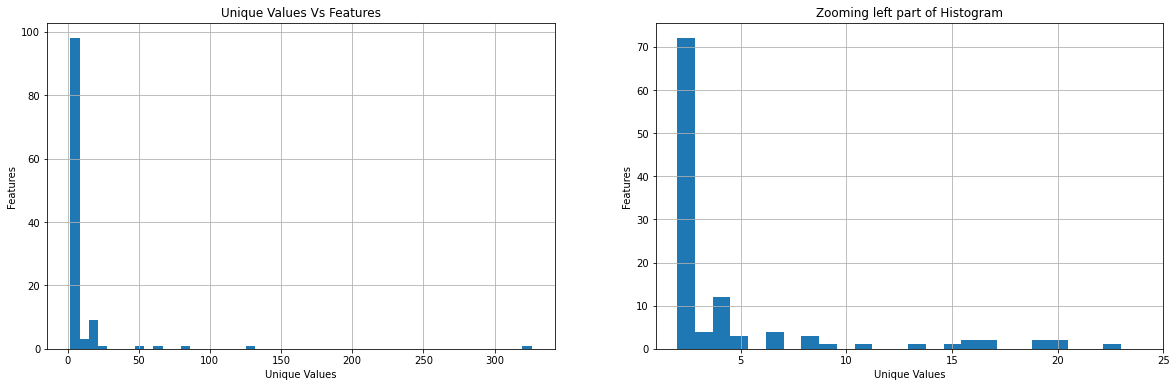

In [9]:
fig, (plt1, plt2) = plt.subplots(1,2)
fig.set_size_inches(20,6)

plt1.grid(True)
plt1.hist(uniqueCategories['Unique Values'], bins=50)
plt1.set_title('Unique Values Vs Features')
plt1.set_xlabel('Unique Values')
plt1.set_ylabel('Features')

plt2.grid(True)
plt2.hist(uniqueCategories[uniqueCategories['Unique Values']<=25]['Unique Values'], bins=25)
plt2.set_xlim(1,25)
plt2.set_title('Zooming left part of Histogram')
plt2.set_xlabel('Unique Values')
plt2.set_ylabel('Features')

### Observations
* Most of the features(almost 75) have unique values less than 3
* Very few features have more number of unique values
* Only one feature has more than 300 unique values 

### Histogram of Numerical features

array([[<AxesSubplot:title={'center':'cont1'}>,
        <AxesSubplot:title={'center':'cont2'}>,
        <AxesSubplot:title={'center':'cont3'}>,
        <AxesSubplot:title={'center':'cont4'}>],
       [<AxesSubplot:title={'center':'cont5'}>,
        <AxesSubplot:title={'center':'cont6'}>,
        <AxesSubplot:title={'center':'cont7'}>,
        <AxesSubplot:title={'center':'cont8'}>],
       [<AxesSubplot:title={'center':'cont9'}>,
        <AxesSubplot:title={'center':'cont10'}>,
        <AxesSubplot:title={'center':'cont11'}>,
        <AxesSubplot:title={'center':'cont12'}>],
       [<AxesSubplot:title={'center':'cont13'}>,
        <AxesSubplot:title={'center':'cont14'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

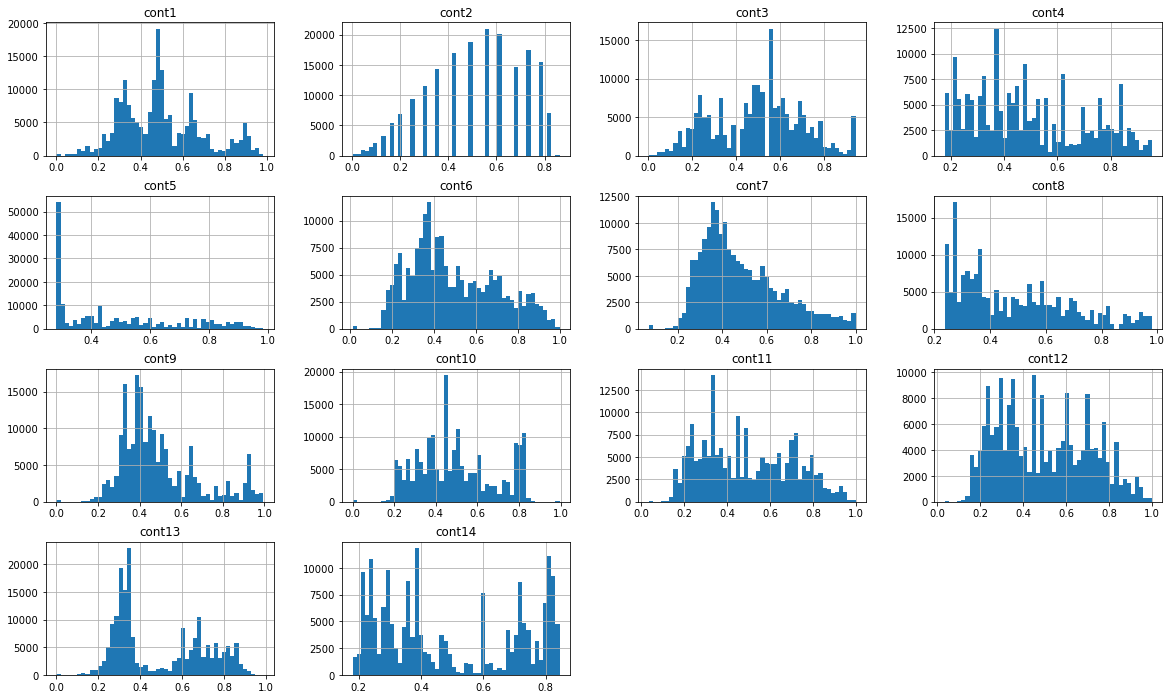

In [10]:
trainData[trainNumerical].hist(bins=50,figsize=(20,12))

### Observations:
* We can notice that distributions of numerical/continous features vary a lot.
* There is no uniformity in the PDFs of these features

### Boxplot of Numerical features

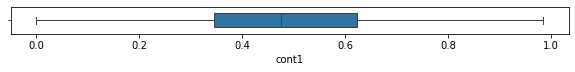

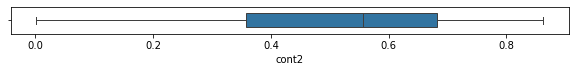

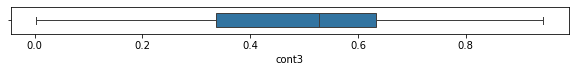

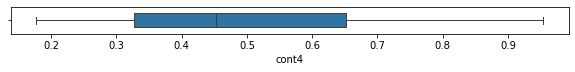

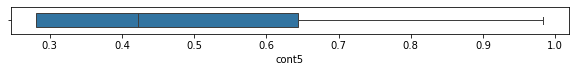

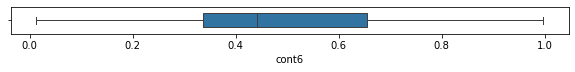

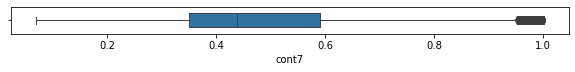

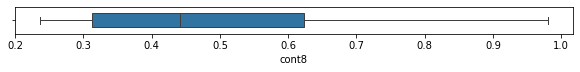

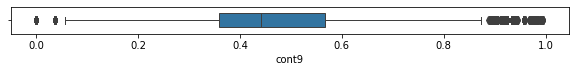

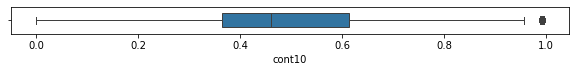

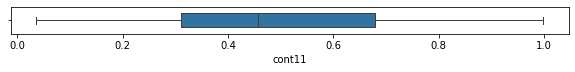

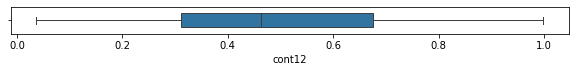

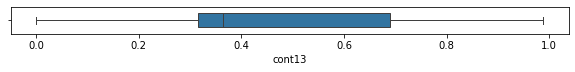

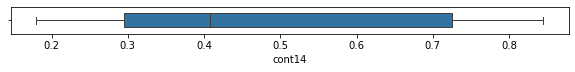

In [11]:
for i in trainNumerical:
    plt.figure(figsize=(10,0.5))
    sns.boxplot(x=trainData[i],width=0.5,linewidth=1.0)

### Observations:
* All values lie in the range 0 t0 1 which means data is already normalized.
* Mean values for most of the features lie around 0.5

In [12]:
trainData[trainNumerical].describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717
std,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488
min,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722
25%,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610
50%,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403
75%,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623
max,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848


### Observations:
* Values of all the numerical features ranges in 0 to 1.
* Mean values of all the features are around 0.5

### Correlation Matrix of Numerical features

<AxesSubplot:>

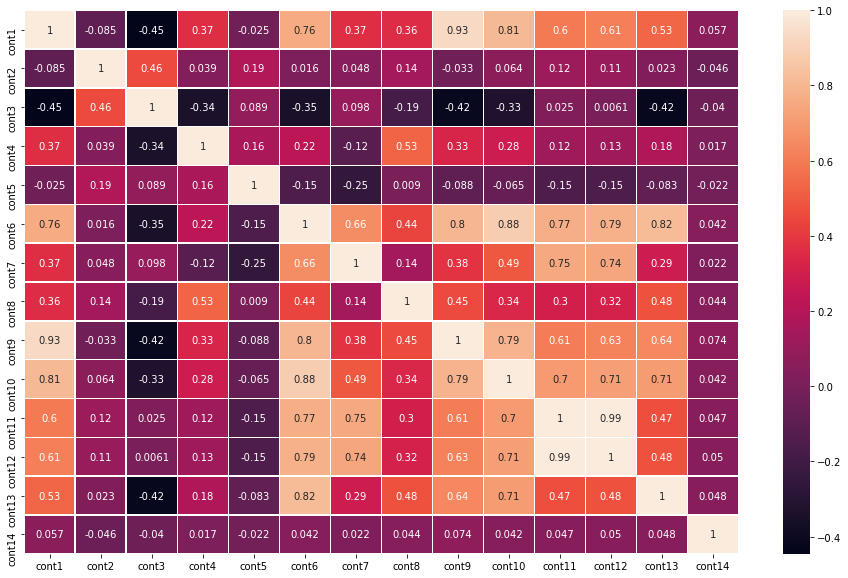

In [13]:
corrMat = trainData[trainNumerical].corr()
plt.figure(figsize=(16,10))
sns.heatmap(corrMat,annot=True,linewidths=0.5)

### Observations:
* In correlation matrix light color blocks indicates highly correlated features and dark blocks indicates less correlated features.
* Some of the features are highly correlated i.e. cont11 and cont12 has correlation coefficient value as 0.99which means they are very similar to each other
* We can remove these highly correlated features but on the other hand as the feature names are made anonymous it may result in performance drop.

### Analysis of Target Variable

Text(0.5, 1.0, 'ID Vs Loss')

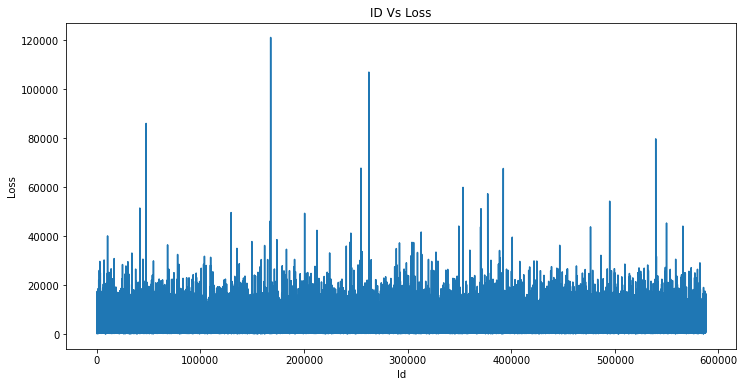

In [14]:
plt.figure(figsize=(12,6))

plt.plot(trainData['id'],trainData['loss'])
plt.xlabel('Id')
plt.ylabel('Loss')
plt.title('ID Vs Loss')

### Observations:
* We can see many spikes in the above plot which represents huge loss at some times.
* As there are many spikes in actual data we can conclude that loss feature is skewed.

### Calculate Skewness of Loss feature

In [15]:
print('Skewness of loss feature is : ',trainData['loss'].skew())

Skewness of loss feature is :  3.7949583775378604


In [16]:
print('Skewness of loss feature after applying log function: ',np.log(trainData['loss']).skew())

Skewness of loss feature after applying log function:  0.09297454555136214


### Observations:
* Loss feature is highly skewed as skewness of this feature is 3.79
* By applying log transformation skewness is decreased to 0.09297

### Histogram of Target variable

Text(0.5, 1.0, 'Train Loss')

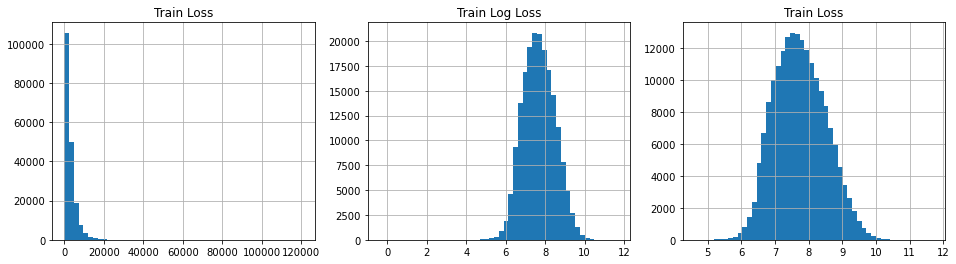

In [17]:
fig, (plt1,plt2,plt3) = plt.subplots(1,3)
fig.set_size_inches(16,4)

plt1.grid(True)
plt1.hist(trainData['loss'],bins=50)
plt1.set_title('Train Loss')

plt2.grid(True)
plt2.hist(np.log(trainData['loss']),bins=50)
plt2.set_title('Train Log Loss')

plt3.grid(True)
plt3.hist(np.log(trainData['loss']+100),bins=50)
plt3.set_title('Train Loss')

### Observations:
* From first histogram of actual values of target variable we can conclude that the distribution is not uniform.
* After applying log transformation(Plot 2) we can observe that the distribution is very similar to normal distribution but mean is not centered at zero.
* If we add a shift of 100 to loss then the distribution actually looks good.

### Boxplot of Target Variable

<AxesSubplot:xlabel='loss'>

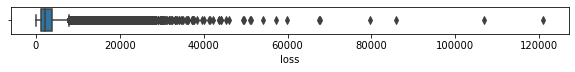

In [18]:
plt.figure(figsize=(10,0.5))
sns.boxplot(trainData['loss'])

Text(0.5, 1.0, 'Zooming lower part of Box plot')

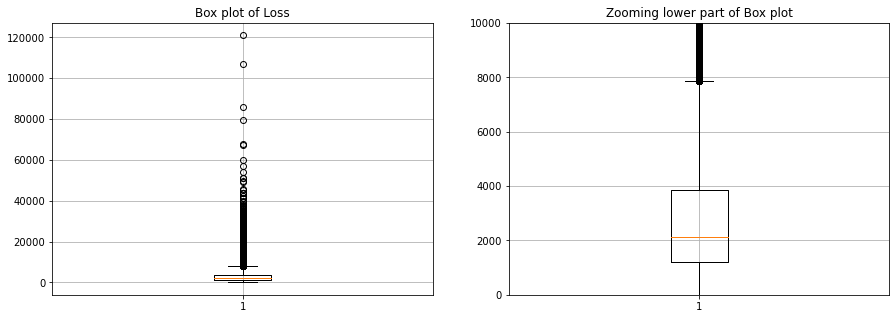

In [19]:
fig, (plt1,plt2) = plt.subplots(1,2)
fig.set_size_inches(15,5)

plt1.grid(True)
plt1.boxplot(x=trainData['loss'])
plt1.set_title('Box plot of Loss')

plt2.grid(True)
plt2.boxplot(x=trainData['loss'])
plt2.set_ylim(0,10000)
plt2.set_title('Zooming lower part of Box plot')

### Observations:
* Most of the 25<sup>th</sup>, 50<sup>th</sup> and 75<sup>th</sup> percentile values are less.
* Some points has very high loss. Usually we consider them as outliars and remove them but in this case we should not drop them as company incured huge loss at these points.

### Train & Test Distributions
* We need to wheather check train and test data are from similar distributions or not. If both are from similar distributions then we can do train test split for cross validation as well.
* There are many techniques to check distributions like welch's test.
* We will merge both train and test data and include a new target variable as 1 for train and 0 for test data and build a simple model.
* If model performs very bad, it means both come from similar distributions.

### Preparing Data

In [20]:
trainDropped = trainData.drop(['id','loss'],axis=1)
testDropped = testData.drop(['id'],axis=1)

print('Shape of train data after dropping: ',trainDropped.shape)
print('Shape of test data after dropping: ',testDropped.shape)

Shape of train data after dropping:  (188318, 130)
Shape of test data after dropping:  (125546, 130)


In [21]:
trainDropped['target'] = 1
testDropped['target'] = 0
finalDF = pd.concat((trainDropped,testDropped))

In [22]:
dataCopy = deepcopy(finalDF)
for i in range(len(trainCategorical)):
    dataCopy[trainCategorical[i]] = dataCopy[trainCategorical[i]].astype('category').cat.codes
print('Shape of data after LabelEncoding: ',dataCopy.shape)

Shape of data after LabelEncoding:  (313864, 131)


In [23]:
dataCopy = shuffle(dataCopy)

In [24]:
x = dataCopy.drop(['target'],axis=1)
y = dataCopy['target']

xTrain, xTest, yTrain, yTest = train_test_split(x,y,test_size=0.3)

print('Shape of xTrain: ',xTrain.shape)
print('Shape of xTest: ',xTest.shape)
print('Shape of yTrain: ',yTrain.shape)
print('Shape of yTest: ',yTest.shape)

Shape of xTrain:  (219704, 130)
Shape of xTest:  (94160, 130)
Shape of yTrain:  (219704,)
Shape of yTest:  (94160,)


### Building model

In [25]:
model = LogisticRegression()
model.fit(xTrain,yTrain)
yPredTest = model.predict(xTest)

In [26]:
testAUC = AUC(yTest,yPredTest)

print('AUC score of LogisticRegression: ',testAUC)

AUC score of LogisticRegression:  0.5


## Building another model

In [27]:
model = RandomForestClassifier(n_jobs=-1)
model.fit(xTrain,yTrain)
yPredTest = model.predict(xTest)

In [28]:
testAUC = AUC(yTest,yPredTest)

print('AUC score of RandomForestClasifier: ',testAUC)

AUC score of RandomForestClasifier:  0.500220703787015


### Observations:
* As for both the models AUC score is 50%. We can conclude that both train and test data have similar distributions.

### Feature Importance

In [29]:
features = [col for col in trainData.columns if col not in ['id','loss']]
featImp = dict(zip(features,model.feature_importances_))
impFeatures = sorted(featImp,key=featImp.get,reverse=True)
impFeaturesValues = [featImp[x] for x in impFeatures]

featureImportance = pd.DataFrame(data={'Feature': impFeatures, 'Importance': impFeaturesValues})
featureImportance.head()

,Feature,Importance
0,cont14,0.078680
1,cat112,0.053332
2,cat100,0.039323
3,cont7,0.038817
4,cont2,0.029465


[Text(0.5, 0, 'Feature Name'),
 Text(0, 0.5, 'Importance'),
 Text(0.5, 1.0, 'Feature Importances')]

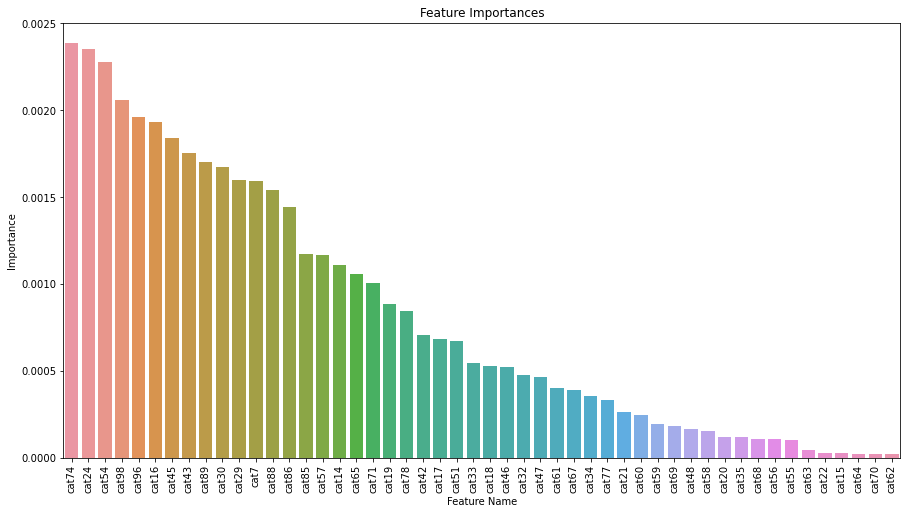

In [30]:
fig, plt1 = plt.subplots()

fig.set_size_inches(15,8)
plt.xticks(rotation='vertical')
sns.barplot(data=featureImportance.iloc[-50:], x="Feature", y="Importance", ax=plt1)
plt1.set(xlabel="Feature Name", ylabel='Importance', title="Feature Importances")

### Observations:
* Most of the features like cat22,cat15,c at 70 have very low FI.

### Principal Component Analysis

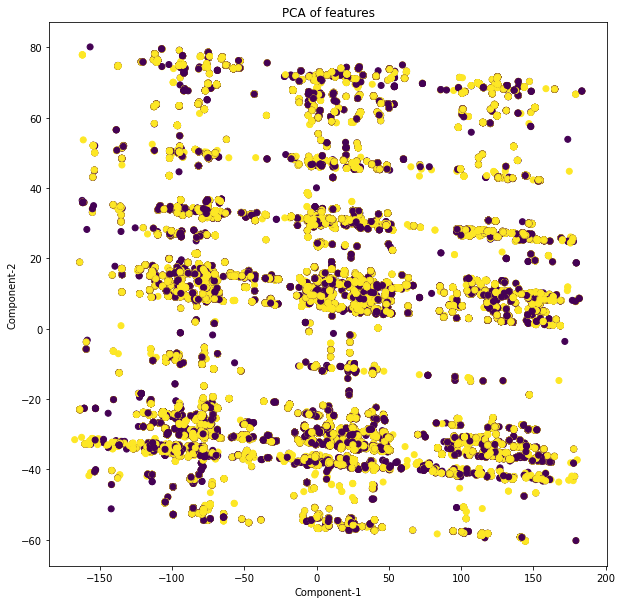

In [31]:
dataCopy = shuffle(dataCopy)
X = dataCopy.iloc[:, :130]
Y = dataCopy.iloc[:, 130:]
pca = PCA(n_components = 2)
reduced_X = pca.fit_transform(X)

plt.figure(figsize = (10,10))
plt.scatter(reduced_X[:,0],reduced_X[:,1],c = np.array(y))
plt.title('PCA of features')
plt.xlabel('Component-1')
plt.ylabel('Component-2')
plt.show()

### Observations:
* We can observe that data is not linearly seperable using PCA.